##### Figure S10, Table S8: Plotting G123 and G2/G1 in the vicinity of two putative candidate sweeps identified by SweepFinder; identifying genome-wide outlier values to contextualize results

In [1]:
from collections import defaultdict
import dask.array as da
from matplotlib import colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

import itertools

import allel
import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [4]:
chroms_dict = defaultdict(dict)

chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_1 (18443972, 131, 2)
AaegL5_2 (32930875, 131, 2)
AaegL5_3 (27660249, 131, 2)


In [5]:
np.sum([chroms_dict[chrom]["gt"].shape[0] for chrom in chroms])

79035096

##### read in metadata

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [7]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### drop close kin

In [8]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### filter by country

In [10]:
countries = md_filtered["country"].unique()

country_bools = {}

for country in countries:
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Colombia', 'Kenya', 'Senegal', 'Gabon', 'Brazil', 'USA'])

In [11]:
garud_stats_alts = defaultdict(lambda: defaultdict(dict))

for chrom in ["AaegL5_2", "AaegL5_3"]:
    
    for country in ["Brazil", "Colombia", "USA"]:
        
        flt = country_bools[country]
            
        gt = \
        allel.GenotypeArray(chroms_dict[chrom]["gt"]\
                            [:, to_drop_bool]).subset(sel1 = flt)
                        
        haps = allel.HaplotypeArray(gt.to_n_alt())
        
        g1, g12, g123, g2_g1 = allel.moving_garud_h(haps,
                                           size=500,
                                           step=50)
        
        garud_stats_alts[chrom][country]["g1"] = g1
        garud_stats_alts[chrom][country]["g12"] = g12
        garud_stats_alts[chrom][country]["g123"] = g123
        garud_stats_alts[chrom][country]["g2_g1"] = g2_g1
        
        print(country, gt.shape)

<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


Brazil (32930875, 16, 2)


<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


Colombia (32930875, 32, 2)


<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


USA (32930875, 26, 2)


<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


Brazil (27660249, 16, 2)


<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


Colombia (27660249, 32, 2)


<ipython-input-11-5c4a3cabacf8>:10: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  allel.GenotypeArray(chroms_dict[chrom]["gt"]\


USA (27660249, 26, 2)


##### average the corresponding positions

In [12]:
pos_windows = defaultdict(dict)

for chrom in ["AaegL5_2", "AaegL5_3"]:

    pos_windows[chrom] = \
    allel.moving_statistic(chroms_dict[chrom]["pos"].compute(),
                          np.mean, size=500, step=50)

##### how many windows?

In [13]:
for chrom in ["AaegL5_2", "AaegL5_3"]:
    
    for country in ["Brazil", "Colombia", "USA"]:
        
        print(chrom, country, len(garud_stats_alts[chrom][country]["g123"]))
        print(chrom, country, len(garud_stats_alts[chrom][country]["g2_g1"]))
        print(chrom, country, 
              len(garud_stats_alts[chrom][country]["g123"]))
        print(chrom, country, 
              len(garud_stats_alts[chrom][country]["g2_g1"]), "\n")

AaegL5_2 Brazil 658608
AaegL5_2 Brazil 658608
AaegL5_2 Brazil 658608
AaegL5_2 Brazil 658608 

AaegL5_2 Colombia 658608
AaegL5_2 Colombia 658608
AaegL5_2 Colombia 658608
AaegL5_2 Colombia 658608 

AaegL5_2 USA 658608
AaegL5_2 USA 658608
AaegL5_2 USA 658608
AaegL5_2 USA 658608 

AaegL5_3 Brazil 553195
AaegL5_3 Brazil 553195
AaegL5_3 Brazil 553195
AaegL5_3 Brazil 553195 

AaegL5_3 Colombia 553195
AaegL5_3 Colombia 553195
AaegL5_3 Colombia 553195
AaegL5_3 Colombia 553195 

AaegL5_3 USA 553195
AaegL5_3 USA 553195
AaegL5_3 USA 553195
AaegL5_3 USA 553195 



##### identify outlier percentiles

In [14]:
percentiles = defaultdict(lambda: defaultdict(dict))
masked_percentiles = defaultdict(lambda: defaultdict(dict))

for chrom in ["AaegL5_2", "AaegL5_3"]:
        
    for country in ["Brazil", "Colombia", "USA"]:
        
        stats = garud_stats_alts[chrom][country]
        
        for cutoff in [0.01, 0.05, 0.95, 0.99]:
        
            percentiles[chrom][country][cutoff] = \
            np.percentile(stats["g2_g1"], [cutoff * 100])[0]

##### calculate the percentage of chromosome-wide extreme windows found in each of the two putative sweeps

##### region 1: chrom 2, 350-355 Mb

##### region 2: chrom 3, 313-318 Mb

In [15]:
region_1_flt = ((pos_windows["AaegL5_2"] >= 350000000) &\
                (pos_windows["AaegL5_2"] <= 355000000))

region_2_flt = ((pos_windows["AaegL5_3"] >= 313000000) &\
                (pos_windows["AaegL5_3"] <= 318000000))

sweep_flts = {"AaegL5_2" : region_1_flt,
             "AaegL5_3" : region_2_flt}

print(np.sum(region_1_flt), np.sum(region_2_flt))

5554 6425


In [16]:
for chrom in ["AaegL5_2", "AaegL5_3"]:
    
    flt = sweep_flts[chrom]
    
    for country in ["Brazil", "Colombia", "USA"]:
        
        stats = garud_stats_alts[chrom][country]
        
        print(chrom, country, "\n")
        
        ##G123 outliers
        g123_denom = np.sum(stats["g123"] == 1)
        g123_num = np.sum(stats["g123"][flt] == 1)
        
        print(f"g123 == 1, whole chromosome: {g123_denom}")
        print(f"g123 == 1, candidate sweep: {g123_num}")
        
        print(
            f"{chrom}, {country}, G123: {g123_num / g123_denom * 100}", "\n")
        
        ##G2/G1 1st percentile outliers
        threshold = percentiles[chrom][country][0.01]
        
        g2_g1_low_denom = np.sum(stats["g2_g1"] <= threshold)
        g2_g1_low_num = np.sum(stats["g2_g1"][flt] <= threshold)
        
        print(f"1st percentile, whole chromosome: {threshold}")
        print(f"g2/g1 <= 1st percentile, whole chromosome: {g2_g1_low_denom}")
        print(f"g2/g1 <= 1st percentile, candidate sweep: {g2_g1_low_num}")
        print(
            f"{chrom}, {country}, G2_G1 low: {g2_g1_low_num / g2_g1_low_denom * 100}", "\n")
        
        ##G2/G1 99th percentile outliers
        threshold = percentiles[chrom][country][0.99]

        g2_g1_high_denom = np.sum(stats["g2_g1"] >= threshold)
        g2_g1_high_num = np.sum(stats["g2_g1"][flt] >= threshold)
        
        print(f"99th percentile, whole chromosome: {threshold}")
        print(f"g2/g1 >= 99th percentile, whole chromosome: {g2_g1_high_denom}")
        print(f"g2/g1 >= 99th percentile, candidate sweep: {g2_g1_high_num}")
        print(
            f"{chrom}, {country}, g2/g1 high: {g2_g1_high_num / g2_g1_high_denom * 100}", "\n")
        


AaegL5_2 Brazil 

g123 == 1, whole chromosome: 287
g123 == 1, candidate sweep: 16
AaegL5_2, Brazil, G123: 5.574912891986063 

1st percentile, whole chromosome: 0.21739130434782608
g2/g1 <= 1st percentile, whole chromosome: 7811
g2/g1 <= 1st percentile, candidate sweep: 228
AaegL5_2, Brazil, G2_G1 low: 2.9189604404045575 

99th percentile, whole chromosome: 0.9375
g2/g1 >= 99th percentile, whole chromosome: 522639
g2/g1 >= 99th percentile, candidate sweep: 4186
AaegL5_2, Brazil, g2/g1 high: 0.8009352535880407 

AaegL5_2 Colombia 

g123 == 1, whole chromosome: 38
g123 == 1, candidate sweep: 8
AaegL5_2, Colombia, G123: 21.052631578947366 

1st percentile, whole chromosome: 0.10106382978723404
g2/g1 <= 1st percentile, whole chromosome: 6744
g2/g1 <= 1st percentile, candidate sweep: 209
AaegL5_2, Colombia, G2_G1 low: 3.0990510083036775 

99th percentile, whole chromosome: 0.96875
g2/g1 >= 99th percentile, whole chromosome: 397005
g2/g1 >= 99th percentile, candidate sweep: 3093
AaegL5_2, Col

##### check the 5%/95% thresholds also

In [17]:
for chrom in ["AaegL5_2", "AaegL5_3"]:
    
    flt = sweep_flts[chrom]
    
    for country in ["Brazil", "Colombia", "USA"]:
        
        stats = garud_stats_alts[chrom][country]
        
        print(chrom, country, "\n")
        
        ##G123 outliers
        g123_denom = np.sum(stats["g123"] >= 0.9)
        g123_num = np.sum(stats["g123"][flt] >= 0.9)
        
        print(f"g123 >= 0.9, whole chromosome: {g123_denom}")
        print(f"g123 >= 0.9, candidate sweep: {g123_num}")
        
        print(
            f"{chrom}, {country}, G123: {g123_num / g123_denom * 100}", "\n")
        
        ##G2/G1 5th percentile outliers
        threshold = percentiles[chrom][country][0.05]
        
        g2_g1_low_denom = np.sum(stats["g2_g1"] <= threshold)
        g2_g1_low_num = np.sum(stats["g2_g1"][flt] <= threshold)
        
        print(f"5th percentile, whole chromosome: {threshold}")
        print(f"g2/g1 <= 5th percentile, whole chromosome: {g2_g1_low_denom}")
        print(f"g2/g1 <= 5th percentile, candidate sweep: {g2_g1_low_num}")
        print(
            f"{chrom}, {country}, G2_G1 low: {g2_g1_low_num / g2_g1_low_denom * 100}", "\n")
        
        ##G2/G1 95th percentile outliers
        threshold = percentiles[chrom][country][0.95]

        g2_g1_high_denom = np.sum(stats["g2_g1"] >= threshold)
        g2_g1_high_num = np.sum(stats["g2_g1"][flt] >= threshold)
        
        print(f"95th percentile, whole chromosome: {threshold}")
        print(f"g2/g1 >= 95th percentile, whole chromosome: {g2_g1_high_denom}")
        print(f"g2/g1 >= 95th percentile, candidate sweep: {g2_g1_high_num}")
        print(
            f"{chrom}, {country}, g2/g1 high: {g2_g1_high_num / g2_g1_high_denom * 100}", "\n")
        


AaegL5_2 Brazil 

g123 >= 0.9, whole chromosome: 287
g123 >= 0.9, candidate sweep: 16
AaegL5_2, Brazil, G123: 5.574912891986063 

5th percentile, whole chromosome: 0.5909090909090909
g2/g1 <= 5th percentile, whole chromosome: 45436
g2/g1 <= 5th percentile, candidate sweep: 614
AaegL5_2, Brazil, G2_G1 low: 1.3513513513513513 

95th percentile, whole chromosome: 0.9375
g2/g1 >= 95th percentile, whole chromosome: 522639
g2/g1 >= 95th percentile, candidate sweep: 4186
AaegL5_2, Brazil, g2/g1 high: 0.8009352535880407 

AaegL5_2 Colombia 

g123 >= 0.9, whole chromosome: 85
g123 >= 0.9, candidate sweep: 16
AaegL5_2, Colombia, G123: 18.823529411764707 

5th percentile, whole chromosome: 0.37254901960784315
g2/g1 <= 5th percentile, whole chromosome: 33284
g2/g1 <= 5th percentile, candidate sweep: 577
AaegL5_2, Colombia, G2_G1 low: 1.7335656772022594 

95th percentile, whole chromosome: 0.96875
g2/g1 >= 95th percentile, whole chromosome: 397005
g2/g1 >= 95th percentile, candidate sweep: 3093
Aae

##### read in genes, and plot

In [18]:
gff3 = pd.read_table(f"{base_path}refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

gff3.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
1,AaegL5_3,VEuPathDB,mRNA,157422094,157436357,.,-,.,ID=AAEL010223-RB;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RB
2,AaegL5_3,VEuPathDB,mRNA,157422094,157436356,.,-,.,ID=AAEL010223-RF;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RF
3,AaegL5_3,VEuPathDB,mRNA,157422094,157436399,.,-,.,ID=AAEL010223-RD;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RD
4,AaegL5_3,VEuPathDB,mRNA,157422094,157471670,.,-,.,ID=AAEL010223-RE;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RE


In [19]:
gene_flt = ((gff3["type"] != "CDS") &\
            (gff3["type"] != "exon") &\
            (gff3["type"] != "five_prime_UTR") &\
            (gff3["type"] != "mRNA") &\
            (gff3["type"] != "three_prime_UTR") &\
            (gff3["type"] != "lnc_RNA") &\
            (gff3["type"] != "pseudogenic_transcript") &\
            (gff3["type"] != "pseudogene"))

genes = gff3.loc[gene_flt, :]

genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
64,AaegL5_3,VEuPathDB,ncRNA_gene,183218064,183218262,.,-,.,ID=AAEL028866;description=unspecified product,AAEL028866
65,AaegL5_3,VEuPathDB,snoRNA,183218064,183218262,.,-,.,ID=AAEL028866-RA;Parent=AAEL028866;description...,AAEL028866-RA
67,AaegL5_2,VEuPathDB,protein_coding_gene,65150768,65155203,.,-,.,ID=AAEL013940;description=chromatin assembly f...,AAEL013940
79,AaegL5_2,VEuPathDB,protein_coding_gene,303181186,303183527,.,+,.,ID=AAEL002384;description=unspecified product,AAEL002384


In [20]:
genes_1 = genes.loc[genes["seqid"] == "AaegL5_1"]
genes_2 = genes.loc[genes["seqid"] == "AaegL5_2"]
genes_3 = genes.loc[genes["seqid"] == "AaegL5_3"]

In [21]:
outString = ingenos.make_date_stamp(
    results_path + "g12/Americas_sweeps_a_and_b_500_variants_g_stats_n_alts", 
    ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/g12/Americas_sweeps_a_and_b_500_variants_g_stats_n_alts.020923.pdf'

In [22]:
row_1_starts = itertools.cycle([0.05, 0.12, 0.19])

row_2_starts = itertools.cycle([0.55, 0.62, 0.69])

#cmap = plt.get_cmap("tab10")
colors = plt.get_cmap("tab10").colors

colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

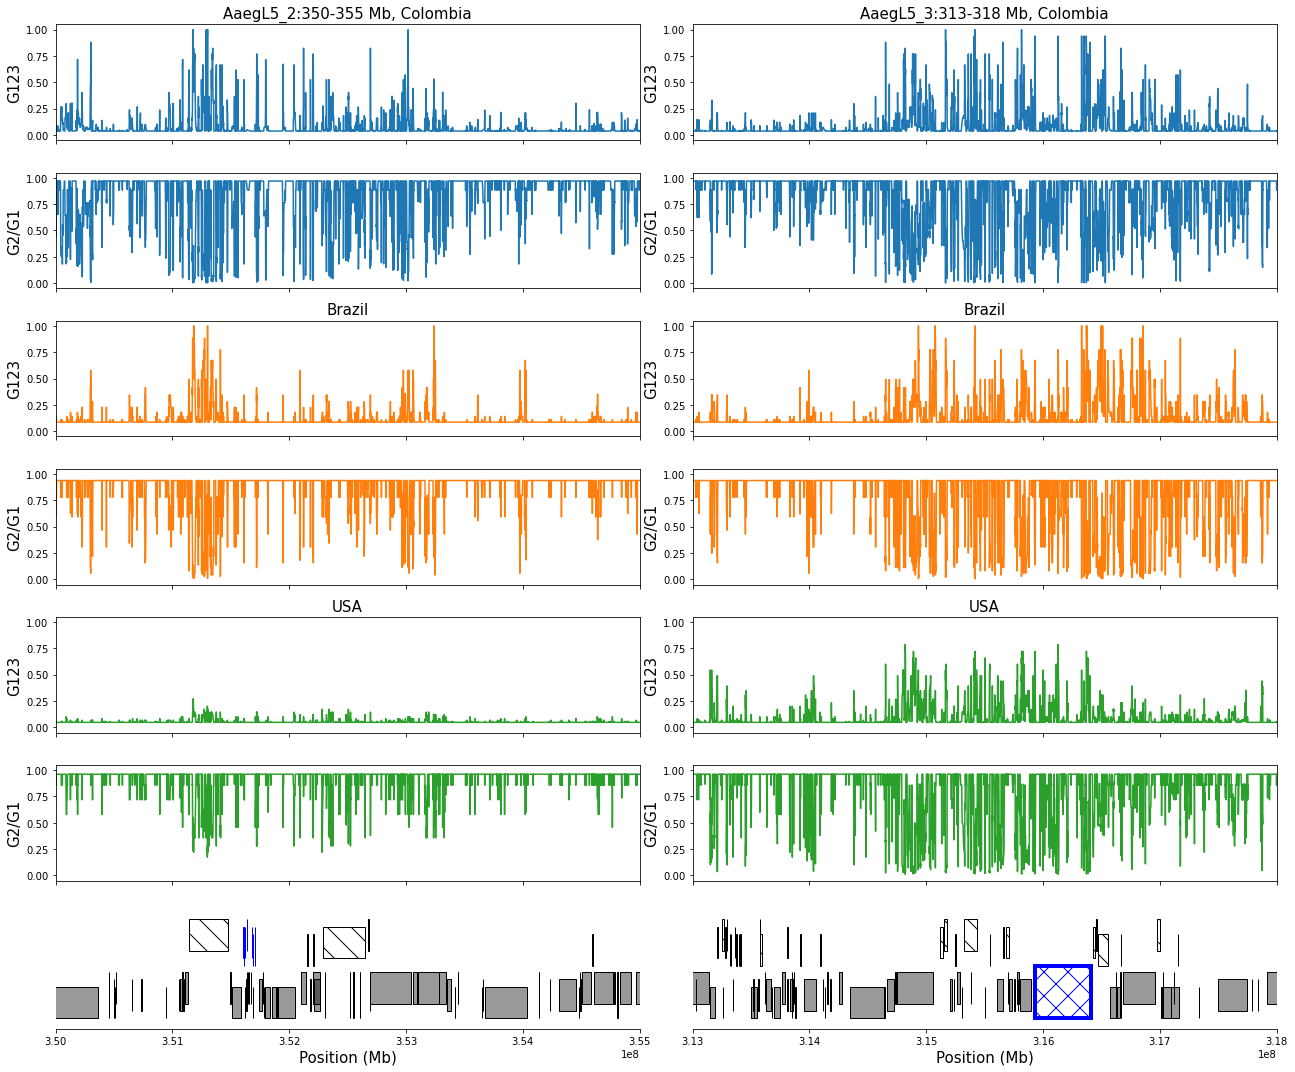

In [23]:
fig, axes = plt.subplots(nrows=7, ncols=2, sharex="col", sharey="col",
                       figsize=(18, 15))

##GSTs
chrom = "AaegL5_2"

for i, country in enumerate(["Colombia", "Brazil", "USA"]):
    
    ax = axes[2*i, 0]
    
    ax.plot(pos_windows[chrom], garud_stats_alts[chrom][country]["g123"],
           color = colors[i])
    
    if i == 0:
    
        ax.set_title(f"AaegL5_2:350-355 Mb, {country}", fontsize=15)
        
    else:
        
        ax.set_title(country, fontsize=15)
    
    ax.set_ylabel("G123", fontsize=15)
    
    ax.set_xlim([350000000, 355000000])
    
    ax = axes[2*i+1, 0]
    
    ax.plot(pos_windows[chrom], garud_stats_alts[chrom][country]["g2_g1"],
           color = colors[i])
        
    ax.set_ylabel("G2/G1", fontsize=15)
    
chunk = genes_2.loc[((genes_2["start"] > 300000000) &\
                     (genes_2["start"] < 400000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "glutathione transferase" in row["attributes"]:
        
            start = next(row_2_starts)
        
            rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                     edgecolor = mpl_colors.to_rgba("blue", 1), 
                                     facecolor = mpl_colors.to_rgba("white", 0),
                                     hatch = "xx")
    
    elif "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:

            start = next(row_2_starts)
        
            rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                     edgecolor = mpl_colors.to_rgba("black", 1), 
                                     facecolor = mpl_colors.to_rgba("white", 0),
                                     hatch = "\\")
        
    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                 edgecolor = mpl_colors.to_rgba("black", 1), 
                                 facecolor = mpl_colors.to_rgba("black", 0.4))
    
    axes[-1, 0].add_patch(rect)
        
##VGSC
chrom = "AaegL5_3"

for i, country in enumerate(["Colombia", "Brazil", "USA"]):
    
    ax = axes[2*i, 1]
    
    ax.plot(pos_windows[chrom], garud_stats_alts[chrom][country]["g123"],
           color = colors[i])
    
    if i == 0:
        ax.set_title(f"AaegL5_3:313-318 Mb, {country}", fontsize=15)
        
    else:
        ax.set_title(country, fontsize=15)
    
    ax.set_ylabel("G123", fontsize=15)
    
    ax.set_xlim([313000000, 318000000])
    
    ax = axes[2*i+1, 1]
    
    ax.plot(pos_windows[chrom], garud_stats_alts[chrom][country]["g2_g1"],
           color = colors[i])
        
    ax.set_ylabel("G2/G1", fontsize=15)
        
chunk = genes_3.loc[((genes_3["start"] > 300000000) &\
                     (genes_3["start"] < 350000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = mpl_colors.to_rgba("black", 1), 
                                             facecolor = mpl_colors.to_rgba("white", 0),
                                             hatch = "\\")
    
    elif "AAEL023266" in row["attributes"]:

        rect = patches.Rectangle((row["start"], 0.05), gene_length, 0.5, linewidth=4,
                            edgecolor = "blue", fill = None, hatch = "x")            
    else:
        
        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = mpl_colors.to_rgba("black", 1), 
                                         facecolor = mpl_colors.to_rgba("black", 0.4))

    axes[-1, 1].add_patch(rect)

for ax in axes[-1, :]:
    
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Position (Mb)", fontsize=15)

plt.tight_layout()

#plt.savefig(outString, bbox_inches="tight")